In [1]:
from leicaexperiment import Experiment

path = r'D:\MatrixScreenerImages\3.3.0_9757'
path += '\\'
e = Experiment(path + 'experiment--2015_04_29_16_35_42 - Copy')

In [2]:
rows = e.rows(0,0)
cols = e.columns(0,0)
rows, cols

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [3]:
import imreg_dft as imreg
from skimage import io

In [49]:
img1 = io.imread(e.image(0,0,0,0))
img2 = io.imread(e.image(0,0,1,0))
imreg.similarity(img1, img2)

{'Dangle': 0.17578125,
 'Dscale': 0.0055387416663735811,
 'Dt': 0.5,
 'angle': 2.4609375,
 'scale': 1.0,
 'success': 0.0299594380433903,
 'timg': array([[ 67.07255352,  65.6997308 ,  65.30995726, ...,  68.97837725,
          68.73551769,  68.21128555],
        [ 68.28330326,  67.73017068,  67.23241115, ...,  69.34348838,
          69.100455  ,  68.76364483],
        [ 69.03026606,  68.70331885,  68.37954885, ...,  69.76915557,
          69.57109243,  69.32645421],
        ..., 
        [ 24.43657777,  32.98088969,  65.66266325, ...,  67.78036981,
          67.06689585,  64.74857274],
        [ 92.9662936 ,  74.3987741 ,  30.62234533, ...,  68.25398436,
          68.07198096,  68.94300395],
        [ 51.43214415,  44.5922982 ,  45.65192651, ...,  68.6440105 ,
          68.48681494,  68.4889648 ]]),
 'tvec': array([  0, -49], dtype=int64)}

In [50]:
0.17578125 / 3.14 * 180

10.076632165605094

In [5]:
translations = []
#for row in rows:
row = 0
prev_p = None
for col in cols:
    p = e.image(0, 0, col, row)
    if prev_p:
        img1 = io.imread(prev_p)
        img2 = io.imread(p)
        translations.append(imreg.translation(img1, img2) + (row, col))
    prev_p = p

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

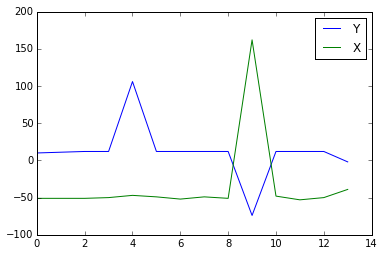

In [7]:
plt.plot([t[0][0] for t in translations])
plt.plot([t[0][1] for t in translations])
plt.legend(('Y', 'X'));

In [8]:
xs = [t[0][1] for t in translations]

In [9]:
[print(x, end=' ') for x in xs];

-51 -51 -51 -50 -47 -49 -52 -49 -51 162 -48 -53 -50 -39 

In [10]:
import numpy as np

In [11]:
np.median(xs)

-50.0

In [12]:
from statsmodels.formula.api import ols

In [13]:
regression = ols('data ~ x', data=dict(data=xs, x=cols[1:])).fit()

In [14]:
outliers_test = regression.outlier_test()
outliers_test

,student_resid,unadj_p,bonf(p)
0,0.008245,9.935695e-01,1.000000e+00
1,-0.041266,9.678233e-01,1.000000e+00
2,-0.088123,9.313631e-01,1.000000e+00
3,-0.115595,9.100569e-01,1.000000e+00
4,-0.107736,9.161449e-01,1.000000e+00
5,-0.187353,8.547950e-01,1.000000e+00
6,-0.284452,7.813477e-01,1.000000e+00
7,-0.278332,7.859199e-01,1.000000e+00
8,-0.361215,7.247805e-01,1.000000e+00
9,60.019405,3.397156e-15,4.756018e-14


In [15]:
outliers_test.icol(2) < 0.5

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
Name: bonf(p), dtype: bool

In [16]:
outliers = np.array(regression.outlier_test().icol(2) < 1)

In [17]:
xs = np.array(xs)
xs[outliers] = np.median(xs)

In [18]:
np.std(xs), np.mean(xs), np.median(xs)

(3.2427312750903332, -49.357142857142854, -50.0)

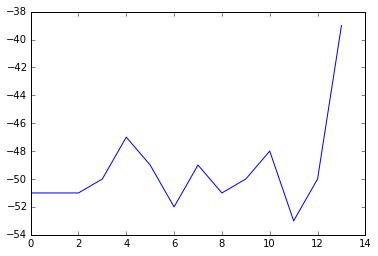

In [19]:
plt.plot(xs)

In [20]:
width = 512*len(cols) + xs.sum()
width

6989

In [21]:
merged = np.zeros((512, width), dtype=np.uint8)

In [22]:
merged[:,0:512] = io.imread(e.image(0,0,0,0))
for col in cols[1:]:
    p = e.image(0,0,col,0)
    offset = sum(xs[:col])
    start = 512*col + offset
    end = start + 512
    merged[:,start:end] = io.imread(p)

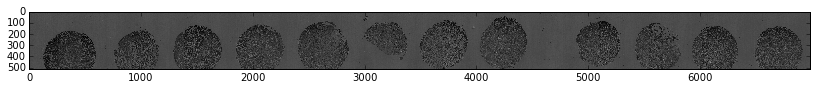

In [23]:
plt.figure(figsize=(14,3))
io.imshow(merged);

In [24]:
def cancel_outliers(data, x, model='data ~ x'):
    """Sets outliers to median(data), assuming statistical model `data ~ x`.
    
    Parameters
    ----------
    data : array like
    x : array like
    model : patsy formula (R compatible)
        See http://patsy.readthedocs.org/en/latest/overview.html
    
    Returns
    -------
    ndarray
        Data with outliers set to median(data).
    """
    equal = False
    i = 0
    while not equal:
        if i > 100:
            raise AssertionError('cancel_outliers should converge')
        before = np.copy(data)
        regression = ols(model, data=dict(data=data, x=x)).fit()
        outliers = np.array(regression.outlier_test().icol(2) < 0.5)
        data[outliers] = np.median(data)
        equal = np.all(before == data)
        i += 1

    # array modified in place, return the reference anyhow
    return data

In [25]:
translations = []
for row in rows:
    prev_p = None
    for col in cols:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            translations.append(imreg.translation(img1, img2) + (row, col))
        prev_p = p
# sanitize data
for i in (0,1):
    translations.sort(key=lambda t: t[0][i])
    data = np.array([t[0][i] for t in translations])
    xs = np.array([t[2+i] for t in translations])
    cancel_outliers(data, xs)
    # update translations
    for n,t in enumerate(translations):
        t[0][i] = data[n]

In [26]:
# sort by col position
translations.sort(key=lambda t: t[3])

In [27]:
x_offsets = np.array([t[0][1] for t in translations])
xs = np.array([t[3] for t in translations])

In [39]:
x_offsets.mean(), max(x_offsets), x_offsets, xs

(-50.987012987012989,
 -48,
 array([-51, -51, -51, -51, -52, -51, -51, -50, -51, -51, -51, -51, -51,
        -54, -54, -53, -51, -51, -51, -51, -51, -51, -52, -51, -51, -51,
        -51, -51, -51, -51, -50, -51, -51, -51, -51, -51, -52, -52, -51,
        -51, -51, -50, -51, -51, -51, -51, -51, -51, -51, -51, -51, -51,
        -51, -51, -51, -51, -51, -52, -52, -50, -50, -50, -49, -49, -49,
        -49, -51, -53, -52, -52, -52, -52, -52, -52, -51, -51, -51, -51,
        -51, -51, -51, -50, -50, -49, -49, -49, -49, -49, -51, -51, -53,
        -51, -51, -51, -50, -51, -51, -51, -51, -51, -51, -51, -51, -51,
        -51, -52, -51, -51, -51, -51, -51, -51, -52, -50, -50, -49, -49,
        -48, -48, -48, -48, -54, -53, -53, -53, -53, -53, -52, -51, -51,
        -51, -51, -51, -51, -51, -51, -51, -51, -50, -50, -50, -50, -50,
        -51, -53, -53, -53, -52, -52, -51, -51, -51, -51, -51], dtype=int64),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,

In [40]:
x_offset = max(x_offsets)
height = img1.shape[0]
single_width = img1.shape[1]
width = len(cols)*single_width + int(cols[-1]*x_offset)
width

7008

In [41]:
row_imgs = []
for row in rows:
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = int(col*x_offset)
        start = single_width*col + offset
        end = start + single_width
        merged[:,start:end] = io.imread(p)
    row_imgs.append(merged)

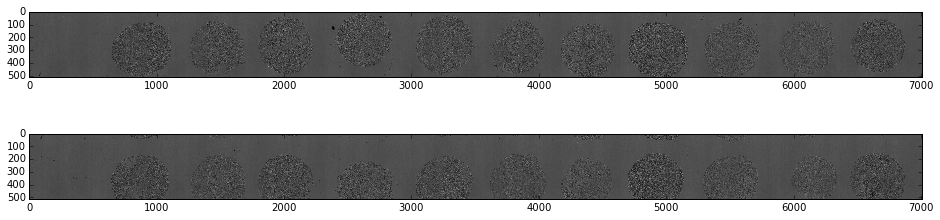

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(211)
io.imshow(row_imgs[5])
plt.subplot(212)
io.imshow(row_imgs[6]);

In [43]:
imreg.translation(row_imgs[0], row_imgs[1])

(array([-52, -12], dtype=int64), 0.036631133459178504)

In [44]:
prev_img = None
row_translations = []
for img in row_imgs:
    if prev_img != None:
        row_translations.append(imreg.translation(prev_img, img))
    prev_img = img
row_translations

C:\Miniconda3\envs\64bit\lib\site-packages\IPython\kernel\__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[(array([-52, -12], dtype=int64), 0.036631133459178504),
 (array([-55, -14], dtype=int64), 0.049498046598641772),
 (array([-51, -12], dtype=int64), 0.047575326904097825),
 (array([-53, -13], dtype=int64), 0.043911937497894661),
 (array([-54, -10], dtype=int64), 0.0068144957487909375),
 (array([-52, -13], dtype=int64), 0.027450213003211734),
 (array([-55, -12], dtype=int64), 0.050985229104158515),
 (array([-53, -13], dtype=int64), 0.053828870120323023),
 (array([-53, -12], dtype=int64), 0.040265036167821969),
 (array([-54, -13], dtype=int64), 0.022144868244873561)]

In [45]:
y_offsets = np.array([t[0][0] for t in row_translations])
cancel_outliers(y_offsets, rows[1:])
y_offset = max(y_offsets)
y_offset, np.median(y_offsets)

(-51, -53.0)

In [46]:
# use calculated offsets
single_height = img1.shape[0]
height = int(len(rows)*single_height + sum(y_offsets))
height

5100

In [47]:
merged = np.zeros((height, width), dtype=np.uint8)
for row,img in enumerate(row_imgs):
    offset = int(sum(y_offsets[:row]))
    start = single_height*row + offset
    end = start + single_height
    merged[start:end,:] = img

In [48]:
io.imsave(e.path + '/stitched-imreg-equalized.png', merged)

In [104]:
np.median(y_offsets)

-58.0

In [107]:
max(y_offsets)

-56

In [111]:
offsets = [t[0][1] for t in translations]

In [114]:
np.mean(offsets), np.median(offsets)

(-58.176470588235297, -58.0)

In [115]:
y_translations = []
for col in cols:
    prev_p = None
    for row in rows:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            y_translations.append(imreg.translation(img1, img2) + (row, col))
        prev_p = p
# sanitize data
for i in (0,1):
    y_translations.sort(key=lambda t: t[0][i])
    data = np.array([t[0][i] for t in y_translations])
    xs = np.array([t[2+i] for t in y_translations])
    cancel_outliers(data, xs)
    # update translations
    for n,t in enumerate(y_translations):
        t[0][i] = data[n]

In [124]:
y_offsets = [t[0][0] for t in y_translations]

In [125]:
np.mean(y_offsets), np.median(y_offsets)

(-58.011111111111113, -58.0)